## 4 - Partie pratique: estimation de densité 

### 4.1-2

In [6]:
from abc import ABC, abstractmethod
import numpy as np
from scipy.stats import multivariate_normal

from abc import ABC, abstractmethod
import numpy as np
from scipy.stats import multivariate_normal

class Model(ABC):
    @abstractmethod
    def train(self, train_inputs, train_labels):
        pass
    
    @abstractmethod
    def predict(self, test_inputs):
        pass

class Gaussian1d(Model):
    def train(self, train_inputs, train_labels):
        self.mean = np.mean(train_inputs, axis=0)
        self.variance = np.sum((train_inputs - self.mean) ** 2, axis=0) / train_inputs.shape[0]

        #  Test
        assert(np.abs(self.variance - np.var(train_inputs.T)) <= 0.00000000000001)

        self.first_half_pdf = 1 / np.sqrt(2 * np.pi * self.variance)
    
    def logpdf(self, x):
        diff = x - self.mean
        second_half_pdf = np.exp(-0.5 * diff ** 2 / self.variance)
        return np.log(self.first_half_pdf * second_half_pdf)
    
    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            predictions[i] = self.logpdf(x)
            
        return predictions
        
class DiagonalGaussian(Model):   
    def train(self, train_inputs, train_labels):
        # Check if we have more than one dimension because numpy functions like inverse and cov require 2d matrices
        if train_inputs.ndim > 1:
            self.mean = np.mean(train_inputs, axis=0)
            self.covariance = np.diag(np.sum((train_inputs - self.mean) ** 2, axis=0) / train_inputs.shape[0])
            #self.covariance = np.diag(np.diag(np.cov(train_inputs.T)))

            #  Test
            assert((np.abs(self.covariance - np.diag(np.diag(np.cov(train_inputs.T, bias=True)))) <= 0.00000000000001).all())

            self.inv_covariance = np.linalg.inv(self.covariance)
            self.first_half_pdf = 1 / np.sqrt((2 * np.pi) ** train_inputs.shape[1] * np.linalg.det(self.covariance))
            self.compute_log_pdf = self.__logpdf__
        else:
            gaussian1d = Gaussian1d()
            gaussian1d.train(train_inputs, train_labels)
            self.compute_log_pdf = gaussian1d.logpdf
            self.mean = gaussian1d.mean
            self.covariance = gaussian1d.variance
    
    def __logpdf__(self, x):
        diff = x - self.mean
        second_half_pdf = np.exp(-0.5 * np.dot(np.dot(diff, self.inv_covariance), diff))
        return np.log(self.first_half_pdf * second_half_pdf)
    
    def logpdf(self, x):
        return self.compute_log_pdf(x)
    
    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            predictions[i] = self.logpdf(x)
            
        return predictions
    
    def test_predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0], 2))
        for i, x in enumerate(test_inputs):
            predictions[i, 0] = multivariate_normal.logpdf(x, mean=self.mean, cov=self.covariance)
            predictions[i, 1] = self.logpdf(x)
            
        assert((np.abs(predictions[:, 0] - predictions[:, 1]) <= 0.00000000000001).all())

class ParzenIsotropicGaussian(Model):
    def __init__(self, std = 1):
        self.std = std
        
    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        
        d = train_inputs.shape[1] if train_inputs.ndim > 1 else 1
        self.first_half_pdf = 1 / ((np.sqrt((2 * np.pi)) * self.std) ** d)
    
    def __pdf__(self, x, mean):
        diff = x - mean
        second_half_pdf = np.exp(-0.5 * (np.linalg.norm(diff) / self.std) ** 2)
        return self.first_half_pdf * second_half_pdf

    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            for X in train_inputs:
                predictions[i] += self.__pdf__(x, X)
                
        predictions /= train_inputs.shape[0]
        return np.log(predictions)
    
    def test_predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0], 2))
        for i, x in enumerate(test_inputs):
            for X in train_inputs:
                predictions[i, 0] += multivariate_normal.pdf(x, mean=X, cov=self.std ** 2)
                predictions[i, 1] += self.__pdf__(x, X)
                
        predictions /= train_inputs.shape[0]
        predictions = np.log(predictions)
        assert((np.abs(predictions[:, 0] - predictions[:, 1]) <= 0.00000000000001).all())


In [3]:
# Test
data = np.loadtxt("./iris.txt")

# Multiple dimensions
train_inputs = data[:50, :4]
train_labels = data[:50, 4]

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)

parzen = ParzenIsotropicGaussian()
parzen.train(train_inputs, train_labels)

dg.test_predict(data[:50, :4])
parzen.test_predict(data[:50, :4])

# One dimension
train_inputs = data[:50, 0]
train_labels = data[:50, 4]

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)

parzen = ParzenIsotropicGaussian()
parzen.train(train_inputs, train_labels)

dg.test_predict(data[:50, 0])
parzen.test_predict(data[:50, 0])

### 4.3

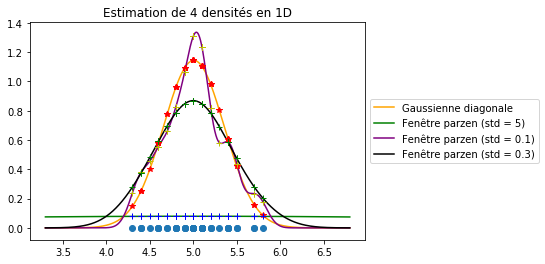

In [29]:
import matplotlib.pyplot as plt
train_inputs = data[:50, 0]
train_labels = data[:50, 4]

feature = data[:50, 0]

min_x = np.min(feature)-1.0
max_x = np.max(feature)+1.0
linespace_indice = np.arange(min_x, max_x, 0.001)

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)
dg_feature_predictions = dg.predict(feature)
dg_linespace_predictions = dg.predict(linespace_indice)

stdTooLarge = 5
stdTooSmall = 0.1
stdOptimal = 0.3

parzen_stdTooBig = ParzenIsotropicGaussian(std=stdTooLarge)
parzen_stdTooBig.train(train_inputs, train_labels)
parzen_stdTooBig_feature_predictions = parzen_stdTooBig.predict(feature)
parzen_stdTooBig_linespace_predictions = parzen_stdTooBig.predict(linespace_indice)

parzen_stdTooSmall = ParzenIsotropicGaussian(std=stdTooSmall)
parzen_stdTooSmall.train(train_inputs, train_labels)
parzen_stdTooSmall_feature_predictions = parzen_stdTooSmall.predict(feature)
parzen_stdTooSmall_linespace_predictions = parzen_stdTooSmall.predict(linespace_indice)

parzen_stdOptimal = ParzenIsotropicGaussian(std=stdOptimal)
parzen_stdOptimal.train(train_inputs, train_labels)
parzen_stdOptimal_feature_predictions = parzen_stdOptimal.predict(feature)
parzen_stdOptimal_linespace_predictions = parzen_stdOptimal.predict(linespace_indice)

plt.scatter(feature, np.zeros(feature.shape))
# Plot de la gaussienne avec le linespace
plt.plot(linespace_indice, np.exp(dg_linespace_predictions), color='orange')

# Plot de parzen avec le linespace
plt.plot(linespace_indice, np.exp(parzen_stdTooBig_linespace_predictions), color='green')

plt.plot(linespace_indice, np.exp(parzen_stdTooSmall_linespace_predictions), color='purple')

plt.plot(linespace_indice, np.exp(parzen_stdOptimal_linespace_predictions), color='black')

plt.legend(["Gaussienne diagonale", "Fenêtre parzen (std = {})".format(stdTooLarge), "Fenêtre parzen (std = {})".format(stdTooSmall), "Fenêtre parzen (std = {})".format(stdOptimal)], loc='center left', bbox_to_anchor=(1, 0.5))

# Plot de la gaussienne avec les trains data
plt.plot(feature, np.exp(dg_feature_predictions), 'r*')

# Plot de parzen avec le train data
plt.plot(feature, np.exp(parzen_stdTooBig_feature_predictions), 'b+')

plt.plot(feature, np.exp(parzen_stdTooSmall_feature_predictions), 'y+')

plt.plot(feature, np.exp(parzen_stdOptimal_feature_predictions), 'g+')

plt.title("Estimation de 4 densités en 1D")

plt.show()

#### Expliquez comment vous avez choisi votre hyper-paramètre σ


En ce qui concerne l'écart-type trop grand, on peut observer le fait que la courbe semble trop applatie. Intuitivement, cela ne semble pas représentatif de la densité des données. Ce phénomène peut s'expliquer par le fait qu'un tel écart-type vient annuler toutes les valeurs lors du calcul de la densité de probabilité. Le modèle souffre donc de sous-apprentissage.

<img src="parzen_1d_std_5.png">

L'écart-type trop petit, quant à lui, présente une courbe irrégulière et avec plusieurs bosses. La courbe ne ressemble pas à une courbe normale et semble souffrir de sur-apprentissage. Ce phénomène est entre autre dû au fait que l'écart-type amplifie trop les valeurs lors du calcul de la densité de probabilité.

<img src="parzen_1d_std_0,1.png">

Enfin, l'écart-type optimal a été sélectionné puisque qu'il permet d'obtenir une courbe normale lisse. Les valeurs d'écart-type autour de 0.2 semble les meilleures. À partir de 0.15 et en descendant, la courbe semble souffrir de sur-apprentissage.

<img src="parzen_1d_std_0,2.png">


### 4.4

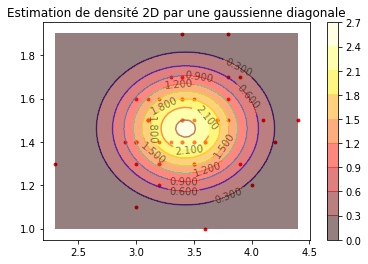

In [31]:
feature = data[:50, 1:3]
train_inputs = data[:50, 1:3]
train_labels = data[:50, 4]

# Calcul des extremités du domaine en x et y
x_min = feature[:,0].min()
x_max = feature[:,0].max()
y_min = feature[:,1].min()
y_max = feature[:,1].max()

# Construction de l'espace d'entrée rectangulaire
xgrid = np.linspace(x_min, x_max, 50)
ygrid = np.linspace(y_min, y_max, 50)
grid = np.array([[x,y] for x in xgrid for y in ygrid])

# Calcul de densité de la Gaussienne istropique 2D
dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)
dg_features_predictions = dg.predict(data[25:50, :2])
dg_linspace_predictions = np.exp(dg.predict(grid)).reshape((50,50)).T


# On fait un nuage de points de notre training set en 2D
plt.scatter(feature[:,0],feature[:,1], s=8, color='r')
# On fait un coutour level ou contour_set de notre plot 3D pour le mettre en 2D
contour_level = plt.contour(xgrid,ygrid,dg_linspace_predictions, 8, alpha=0.5, cmap = plt.cm.jet)
# On peint les bandes contour level
plt.contourf(xgrid,ygrid,dg_linspace_predictions, 8, alpha=0.5, cmap = plt.cm.hot)
# Mets des labels (valeur de densité) sur les contours lines
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
# Affiche à droite un axe avec des informations de couleur étiquetées pour le tracé
plt.colorbar()

plt.title("Estimation de densité 2D par une gaussienne diagonale")

plt.show()

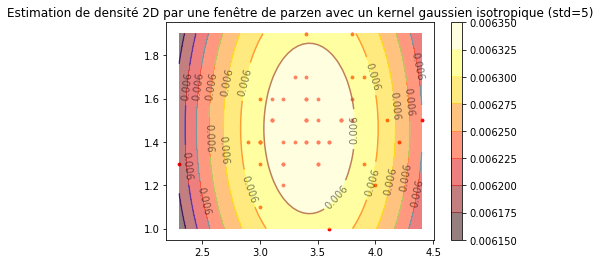

In [32]:
stdTooBig = 5
parzen_stdTooBig = ParzenIsotropicGaussian(std=stdTooBig)
parzen_stdTooBig.train(train_inputs, train_labels)
parzen_stdTooBig_features_predictions = parzen_stdTooBig.predict(data[:50, :2])
parzen_stdTooBig_inline_predictions = np.exp(parzen_stdTooBig.predict(grid)).reshape((50,50)).T

# On fait un nuage de points de notre training set en 2D
plt.scatter(feature[:,0],feature[:,1], s=8, color='r')
# On fait un coutour level ou contour_set de notre plot 3D pour le mettre en 2D
contour_level = plt.contour(xgrid,ygrid,parzen_stdTooBig_inline_predictions, 8, alpha=0.5, cmap = plt.cm.jet)
# On peint les bandes contour level
plt.contourf(xgrid,ygrid,parzen_stdTooBig_inline_predictions, 8, alpha=0.5, cmap = plt.cm.hot)
# Mets des labels (valeur de densité) sur les contours lines
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
# Affiche à droite un axe avec des informations de couleur étiquetées pour le tracé
plt.colorbar()

plt.title('''Estimation de densité 2D par une fenêtre de parzen avec un kernel gaussien isotropique (std={})'''.format(stdTooBig))
plt.show()

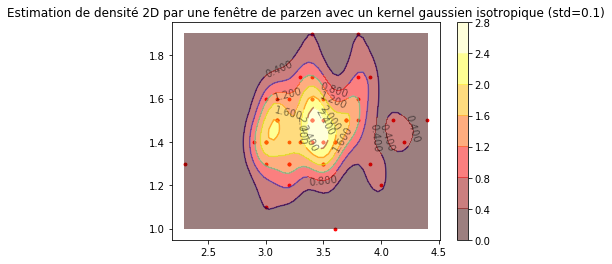

In [25]:
stdTooSmall = 0.1
parzen_stdTooSmall = ParzenIsotropicGaussian(std=stdTooSmall)
parzen_stdTooSmall.train(train_inputs, train_labels)
parzen_stdTooSmall_features_predictions = parzen_stdTooSmall.predict(data[:50, :2])
parzen_stdTooSmall_inline_predictions = np.exp(parzen_stdTooSmall.predict(grid)).reshape((50,50)).T

# On fait un nuage de points de notre training set en 2D
plt.scatter(feature[:,0],feature[:,1], s=8, color='r')
# On fait un coutour level ou contour_set de notre plot 3D pour le mettre en 2D
contour_level = plt.contour(xgrid,ygrid,parzen_stdTooSmall_inline_predictions, 8, alpha=0.5, cmap = plt.cm.jet)
# On peint les bandes contour level
plt.contourf(xgrid,ygrid,parzen_stdTooSmall_inline_predictions, 8, alpha=0.5, cmap = plt.cm.hot)
# Mets des labels (valeur de densité) sur les contours lines
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
# Affiche à droite un axe avec des informations de couleur étiquetées pour le tracé
plt.colorbar()

plt.title('''Estimation de densité 2D par une fenêtre de parzen avec un kernel gaussien isotropique (std={})'''.format(stdTooSmall))
plt.show()

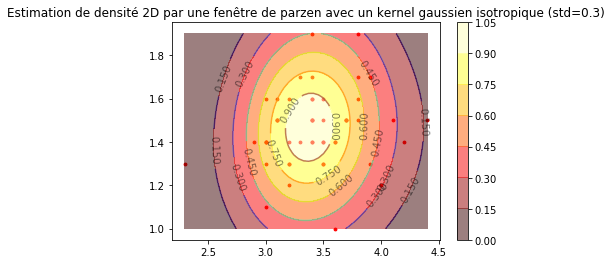

In [27]:
stdOptimal = 0.3
parzen_stdOptimal = ParzenIsotropicGaussian(std=stdOptimal)
parzen_stdOptimal.train(train_inputs, train_labels)
parzen_stdOptimal_features_predictions = parzen_stdOptimal.predict(data[:50, :2])
parzen_stdOptimal_inline_predictions = np.exp(parzen_stdOptimal.predict(grid)).reshape((50,50)).T

# On fait un nuage de points de notre training set en 2D
plt.scatter(feature[:,0],feature[:,1], s=8, color='r')
# On fait un coutour level ou contour_set de notre plot 3D pour le mettre en 2D
contour_level = plt.contour(xgrid,ygrid,parzen_stdOptimal_inline_predictions, 8, alpha=0.5, cmap = plt.cm.jet)
# On peint les bandes contour level
plt.contourf(xgrid,ygrid,parzen_stdOptimal_inline_predictions, 8, alpha=0.5, cmap = plt.cm.hot)
# Mets des labels (valeur de densité) sur les contours lines
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
plt.clabel(contour_level, inline=True, fontsize=10, colors='k')
# Affiche à droite un axe avec des informations de couleur étiquetées pour le tracé
plt.colorbar()

plt.title('''Estimation de densité 2D par une fenêtre de parzen avec un kernel gaussien isotropique (std={})'''.format(stdOptimal))
plt.show()

#### Expliquez comment vous avez choisi votre hyper-paramètre σ

Comme son homologue en 1D, les courbes de densité de l'écart-type trop grand semble manquer de nuances et de regrouper trop de données dans une seule courbe.

Il est facile de voir qu'un écart-type trop petit (0.1), comme dans le cas 1D, donne des courbes de densité qui semblent trop s'adapter aux données. La courbe la plus extérieure est déformée par les points qui sont un peu plus loin du reste. De ce fait, elle ne ressemble pas du tout à un cercle et donc une courbe normale.

L'écart-type optimal forme des courbes proche d'une distribution normale avec un centre contenant moins de points que l'écart-type trop grand et aucune des déformations de l'écart-type trop petit.